In [1]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Size

In [2]:
# size = tlp.ProgressParallel(n_jobs=network_count, total=network_count)(
#   joblib.delayed(get_size)(network_index) for network_index in network_indices
# )
  
# size = pd.DataFrame(size)
size = pd.read_pickle('code/figures/size.pkl')

# Other stats

In [3]:
stats = get_all_stats(network_indices=network_indices) 
stats = stats[['density', 'degree assortativity', 'average clustering coefficient']]
stats

  0%|          | 0/26 [00:00<?, ?it/s]

,density,degree assortativity,average clustering coefficient
1,0.000005,0.114186,0.632629
2,0.008307,0.059906,0.606845
3,0.000079,-0.166689,0.119342
4,0.000219,0.221522,0.123693
5,0.000373,0.177355,0.642282
6,0.009293,0.010808,0.770476
7,0.000009,0.155727,0.606712
8,0.000219,0.221522,0.123693
9,0.000187,0.008341,0.005286
10,0.000040,-0.055707,0.089571


# Diameter

In [4]:
diameter = get_diameter()
diameter

  0%|          | 0/26 [00:00<?, ?it/s]

{1: 23,
 2: 8,
 3: 14,
 4: 16,
 5: 19,
 6: 11,
 7: 22,
 8: 16,
 9: 12,
 10: 18,
 11: 4,
 12: 5,
 13: 6,
 14: 9,
 16: 14,
 18: 10,
 19: 8,
 20: 14,
 21: 13,
 22: 13,
 23: 12,
 24: 8,
 25: 10,
 28: 11,
 29: 17,
 30: 7}

# Static features

In [5]:
def logistic_regression_I(network_index: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

auc_I = {
  network_index: logistic_regression_I(network_index) 
  for network_index in network_indices}
auc_I

{1: 0.6953527059396208,
 2: 0.8222212086294092,
 3: 0.8517442497686755,
 4: 0.7541435765743063,
 5: 0.6865645801331285,
 6: 0.7628612201327163,
 7: 0.7217721278315017,
 8: 0.7628832840197868,
 9: 0.8448093351694936,
 10: 0.9008032194714906,
 11: 0.9306920551021755,
 12: 0.8642720099151482,
 13: 0.7237440295148903,
 14: 0.8735334178881218,
 16: 0.8842385332139512,
 18: 0.8655900531265688,
 19: 0.9186840371926538,
 20: 0.8211898900598091,
 21: 0.6800378435875183,
 22: 0.9372499225360047,
 23: 0.92700848,
 24: 0.7827007038011212,
 25: 0.85552264,
 28: 0.8795061251472457,
 29: 0.906051962051953,
 30: 0.8374009737184345}

# Node temporal features

In [6]:
def logistic_regression_I_II(network_index: int, hypergraph: bool):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(
        f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy'))
    
  if hypergraph:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
        for aggregation_strategy in ['m0', 'm1', 'm2', 'm3', 'q0', 'q25', 'q50', 'q75', 'q100']:
          X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'
            ))
  else:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
          X[(time_strategy, nodepair_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_I_II = {
  network_index: (
    logistic_regression_I_II(
      network_index, hypergraph=network_index in hypergraph_indices
    )
  )
  for network_index in network_indices
}
auc_I_II

{1: 0.7948481575705211,
 2: 0.8666580479875892,
 3: 0.9004990329525964,
 4: 0.7816141865733645,
 5: 0.7262516768171706,
 6: 0.819797331167573,
 7: 0.8277908735274884,
 8: 0.7817326603089026,
 9: 0.8650943293581687,
 10: 0.9154803923074756,
 11: 0.937170868347339,
 12: 0.9018479481405062,
 13: 0.8821742303308917,
 14: 0.9355370747742028,
 16: 0.9392711442893534,
 18: 0.940646491741363,
 19: 0.9355039547084238,
 20: 0.9395187665123805,
 21: 0.7359813413131491,
 22: 0.9675232300929204,
 23: 0.9635138328796324,
 24: 0.9450768667525614,
 25: 0.937084624616735,
 28: 0.9023377496159756,
 29: 0.9189633584093962,
 30: 0.8482955680351545}

# Edge temporal features

In [7]:
def logistic_regression_III(network_index: int, hypergraph: bool):
  X = dict()
  
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      if hypergraph:
        for aggregation_strategy in ['m0', 'm1', 'q0', 'q25', 'q50', 'q75', 'q100']:
            X[(heuristic, time_strategy, aggregation_strategy)] = np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
      else:
        X[(heuristic, time_strategy)] = np.load(
          f'data/{network_index:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_III = {
  network_index: logistic_regression_III(
    network_index, hypergraph=network_index in hypergraph_indices)
  for network_index in network_indices}
auc_III

{1: 0.8040989057551544,
 2: 0.8514816046838667,
 3: 0.8795490435107427,
 4: 0.794940184713866,
 5: 0.7509745326299428,
 6: 0.8129268810928157,
 7: 0.8368061688951695,
 8: 0.8015598381984674,
 9: 0.8466050591112851,
 10: 0.9191025082256052,
 11: 0.9391079338232423,
 12: 0.8926886981297533,
 13: 0.7827376837421043,
 14: 0.9187292881691398,
 16: 0.9333849588819948,
 18: 0.931120926957301,
 19: 0.9235164310505161,
 20: 0.9292441969767878,
 21: 0.7285764206225471,
 22: 0.9618124006308421,
 23: 0.9516174465053742,
 24: 0.8808092086178064,
 25: 0.9040448647178356,
 28: 0.8938962472105961,
 29: 0.9136902757139971,
 30: 0.8457731407169609}

# Figures

In [8]:
df = pd.concat([
  size,
  stats,
  pd.Series(diameter, name='diameter'),
  pd.Series(auc_I, name='time agnostic'),
#   pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='time aware')
], axis=1)
df.columns

Index(['nodes', 'edges', 'density', 'degree assortativity',
       'average clustering coefficient', 'diameter', 'time agnostic',
       'time aware'],
      dtype='object')

In [12]:
df.columns

Index(['nodes', 'edges', 'density', 'degree assortativity',
       'average clustering coefficient', 'diameter', 'time agnostic',
       'time aware'],
      dtype='object')

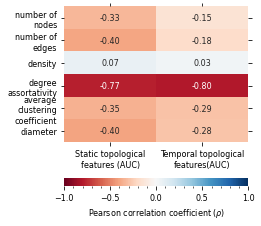

In [15]:
data = (
  df.corr()
  .loc[['time agnostic', 'time aware']]
  .T
  .drop(index=['time aware', 'time agnostic'])
  .rename(
    index={
      'nodes': 'number of\nnodes',
      'edges': 'number of\nedges',
      'average clustering coefficient': 'average\nclustering\ncoefficient',
      'degree assortativity': 'degree\nassortativity'
    },
    columns={
      'time agnostic': 'Static topological\nfeatures (AUC)',
      'time aware': 'Temporal topological\nfeatures(AUC)' 
    }
  )
)

fontsize=8
grid_kws = {"height_ratios": (.9, .05), "hspace": .5}
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.30,3.3), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
  'lines.linewidth': 1,
#   'lines.markersize': 4,
  'legend.handlelength': .1,
  'font.family': 'sans-serif',
  'font.sans-serif': 'Helvetica',
  'savefig.transparent': True
}

with plt.rc_context(rc):
  f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3.3, 3.3))
  ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax,
                   cbar_kws={
                     "orientation": "horizontal", 
                     'label': r'Pearson correlation coefficient ($\rho$)'},
                   vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu',
                   annot_kws={'size': fontsize}
                  )
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
  cbar_ax.xaxis.set_ticks(np.arange(-1, 1.1, .5))
  cbar_ax.xaxis.set_ticks(np.arange(-1, 1.1, .1), minor=True)
  plt.savefig('code/figures/output/Fig4.pdf', bbox_inches='tight')

In [ ]:
from scipy.stats.stats import pearsonr
for column1 in df.columns:
  if column1 in ['nodes', 'edges', 'density', 'degree assortativity', 'average clustering coefficient', 'diameter']:
    for column2 in df.columns:
      if column2 in ['time agnostic', 'time aware']:
        print(column1, column2, pearsonr(df[column1], df[column2]))

In [ ]:
df

In [ ]:
df = pd.concat([
  size,
  stats,
  pd.Series(diameter, name='diameter'),
  pd.Series(auc_I, name='I'),
  pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='III')
], axis=1)

sns.heatmap(
  df.corr(),
  vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu')
plt.yticks(rotation=0) 
# plt.savefig('figures/heatmap.pdf')

In [ ]:
df.sort_values('degree assortativity')